# Train data smoothing algorithm 

## It's the main notebook.


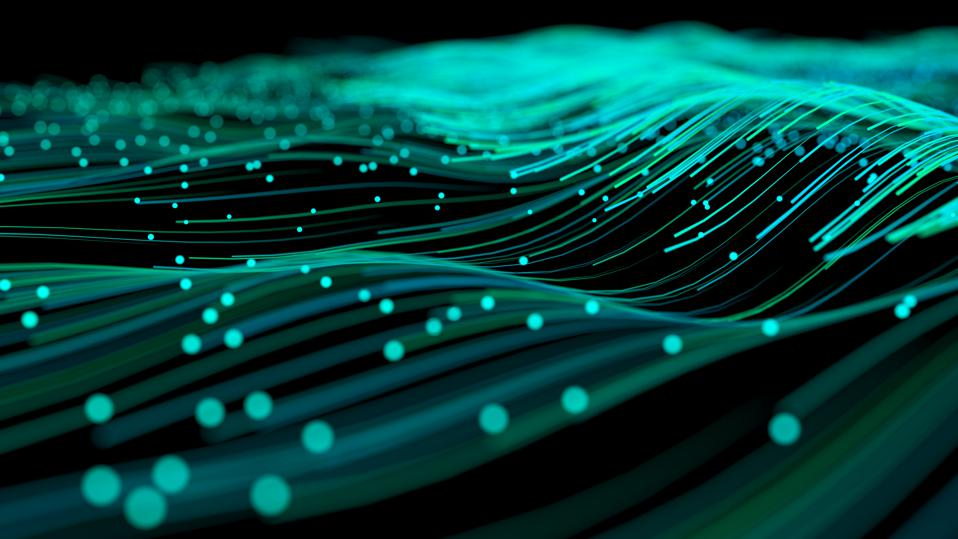

# Background

My first competition on kaggle started with a data frame with a lot of missing data, from 0.01% to 99.5% in about 30 columns. Housing Prices. The whole story began with my first ML algorithm for imputation nan into a raw data frame.

LinkedIn post: https://www.linkedin.com/posts/artyomkolas_hi-everyone-i-have-a-nice-news-i-tried-activity-6731588248403001344-Ggg9

notebook: https://www.kaggle.com/artyomkolas/ml-approach-to-replacing-nan-top-4

The essence of the algorithm is to imputation nan with more accurate values ​​in a raw data frame using ML and one click.
The algorithm showed excellent results and without any other improvements (default) of the data frame gave three results (top 11%, top 9%, top 4% in the Housing Prices leaderboard).

Applying other improvements, I was climbing on the leaderboard.
I was already very close to the top 1%. And I decided to very carefully and meticulously replace nan with more appropriate values ​​in each cell !!! without my algorithm with ML nan imputation. And what did I see ?!! The results in predictions (MAE) have become much worse!!!

For a long time I couldn’t understand: Why did the most logical values turn out to be worse? Then I received new knowledge. Participated in new competitions. And I improved my ML nan impooter algorithm. 


# Hypothesis

The other day the thought came that our world is not ideal. We raise or lower our expectations for purchases or sales, interviews, measurement errors and other factors. A kind of "imputation of subjectivity" and distortions, incl. add outliers.

A hypothesis appeared that the algorithm predicts and inserts, as it were, “more objective” values ​​instead of gaps in accordance with the general field of historical data (“averaged, more objective”). And thus improves the data field (better than real values).

Example: vector of a function (like price)
The minimus and maximums are the price values.
For example: [30,000, 40,000, 20,000, 23,000, ...]


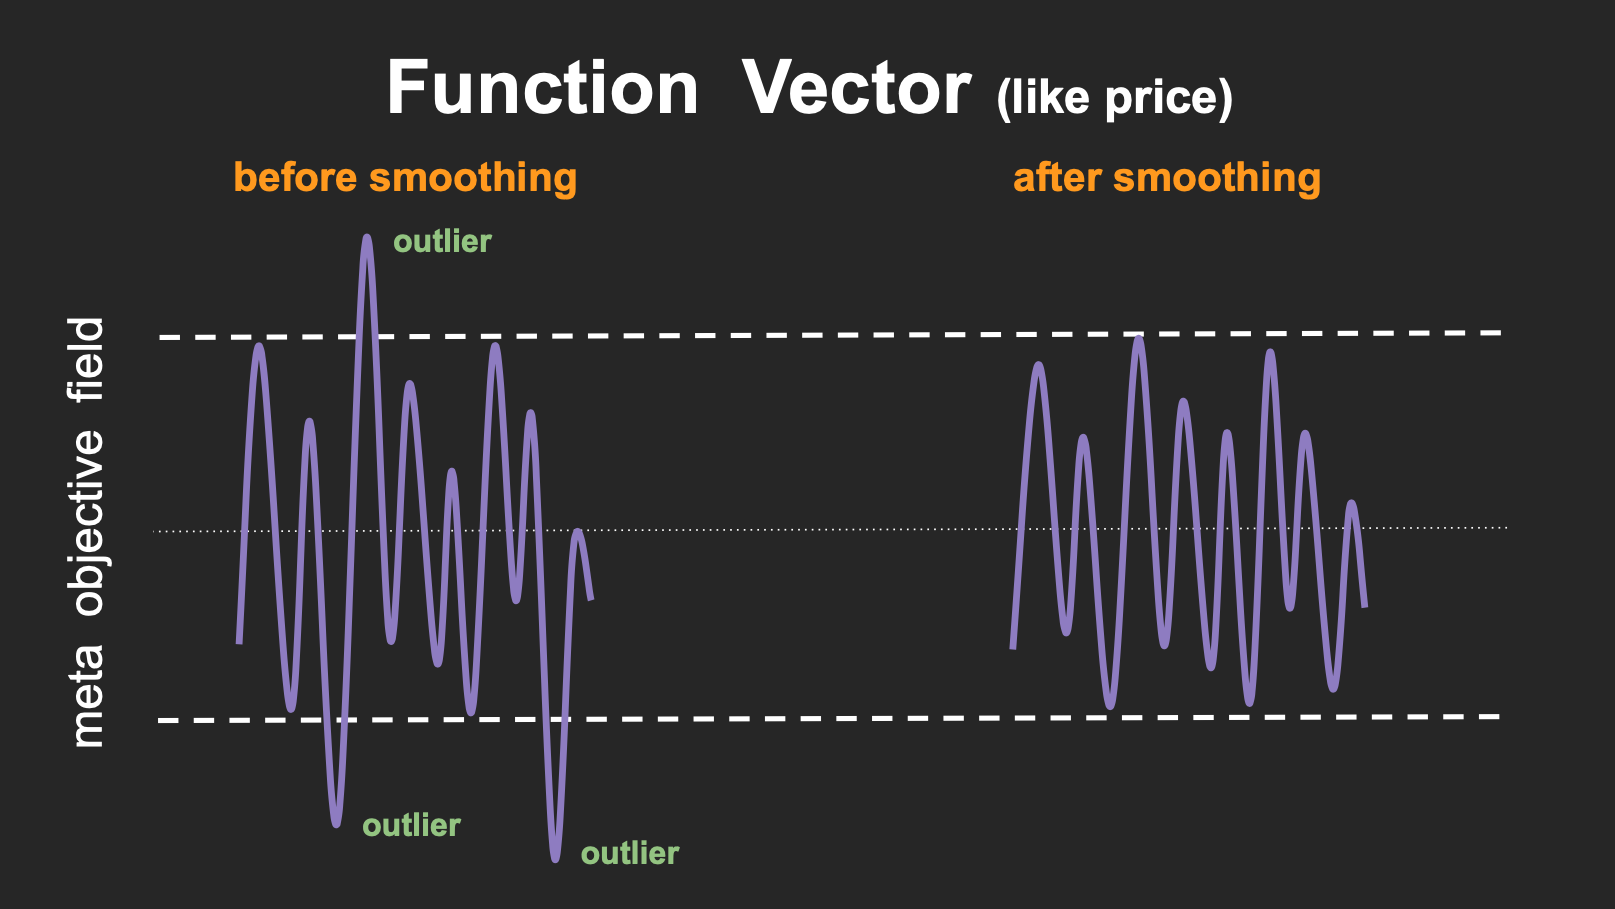

# Challenge
Well. But what if we go all over the data frame and iteratively delete 10% of the data, predict and impute it?   
Will this help to achieve data harmonization and will it add more objectivity?   
Will it improve the data for training the model?   
And finally, does it help train the model more accurately for practical purposes?

# Research  

### Conditions

- everything on lightgbm
- regression (and next classification)
- three different date frames
- all manipulations only with data for training
- test data is only normalized together with training

### I checked it in THREE different ways:
#### 1st
Delete 10% of the data in the first column, predict, imput. Then in the next column 10%, etc.   
Then again to the first column and repeat for all columns with the second 10%.    
Until we have traversed the dataframe by 100%.   
https://www.kaggle.com/artyomkolas/1-ml-data-smoothing-harmonization


#### 2nd
As in the first way, but with the addition of the contribution coefficients to the final    
imputation real values and ML predictions (for example 0.95 and 0.05).   
https://www.kaggle.com/artyomkolas/2-ml-data-smoothing-harmonization-with-contrib

#### 3rd
Predict each column in turn (100%) on the same data as for the trained model (AMAZING😱).   
https://www.kaggle.com/artyomkolas/3-ml-data-smoothing-harmonization-in-columns


# Conclusion

### 1st way - very weak   
### 2nd way and 3rd way work better   
### 3rd work better and also much faster   

### ! Mostly for small data frames ~ 10 000 rows and less

# Attention
- Smoothing can give an increase in accuracy (MAE) of up to 0-20% for small data frames
- strongly depends on data (possibly from outliers and errors)
- work with preprocessed data: train_X, train_y, test_X, test_y

# 3rd way code

### Let's choose data, the target feature and middle of data¶

In [ ]:
import numpy as np
import pandas as pd


test_size_fraction = 0.5
split_random_state = 0


data = "../input/fe-course-data/autos.csv"     # ~ 20%  best result (193 rows × 25 columns)
target_feature = "price"

# data = "../input/fe-course-data/concrete.csv"
# target_feature = "CompressiveStrength"

# data = "../input/fe-course-data/housing.csv"
# target_feature = "HouseAge"

# data = "../input/fe-course-data/ames.csv"
# target_feature = "SalePrice"




df = pd.read_csv(data)


predictors = list(df.columns)
predictors.remove(target_feature)


df

In [ ]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.shape)

# encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder


def encoding(df):
    for j in df.columns:
        el_type = df[j].dtype
        if el_type == 'object':
            df[j].replace(np.nan, 'NoNoNo', inplace=True)
            labelencoder = LabelEncoder()
            df.loc[:, j] = labelencoder.fit_transform(df.loc[:, j])
    return df

encoding(df)

# normalization

In [ ]:
for col in predictors:
    min_x = df[[col]].min()
    max_x = df[[col]].max()
    df[[col]] = (df[[col]] - min_x) / (max_x - min_x)
df

# Let's split data to train and test.

In [ ]:
from sklearn.model_selection import train_test_split



X = df[predictors]
y = df[[target_feature]]


train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=test_size_fraction, random_state=split_random_state)

train_X.reset_index(drop=True, inplace=True)
test_X.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)
test_y.reset_index(drop=True, inplace=True)


print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

# train_X for comparing at the end

In [ ]:
train_X

# Data smoothing REGRESSON

In [ ]:
# for preprocessed train_X, train_y, test_X, test_y

def smoothing_regression(train_X, train_y, test_X, test_y, ML_weight=0.8):
    import numpy as np
    import pandas as pd
    import plotly.graph_objs as go
    from lightgbm import LGBMRegressor
    from sklearn.metrics import mean_absolute_error

    
    global results
    
    REAL_VALUE_weight = 1 - ML_weight

    
    def score(train_X, train_y, test_X, test_y):
        model = LGBMRegressor(random_state=0).fit(train_X, train_y)
        predict = model.predict(test_X)
        score = mean_absolute_error(predict, test_y)
        return score 
    
    
    def plots(results, target_feature):
        baseline = []
        for el in results.index[:]:
            baseline.append(results.iloc[0,0])
 
        trace1 = go.Scatter(
                            x=results.index, 
                            y=baseline, 
                            name="without smoothing", 
                            marker=dict(color = '#FFB3F7',
                                     line=dict(color='#000000',width=1)))
        trace2 = go.Scatter(
                            x=results.index, 
                            y=results['score'], 
                            name="smoothing iterations", 
                            marker=dict(color = '#47E0FF',
                                     line=dict(color='#000000',width=1)))
        layout = go.Layout(hovermode='closest', 
                           title = f'MAE after every iteration for feature: "{target_feature}"' ,
                           xaxis = dict(title = 'smoothed data, columns'), 
                           yaxis = dict(title = 'Mean Absolute Error'), 
                           template= "plotly_dark")
        fig = go.Figure(data = [trace1, trace2], layout=layout)
        return fig.show()
    
    
    def iteration_score(train_X, train_y, test_X, test_y, results, all_columns, target_feature):
        for col in all_columns:
            df_new = pd.concat([train_X,train_y], axis=1)
            X = df_new.copy()
            y = X.pop(col)

            model = LGBMRegressor(random_state=0).fit(X, y)
            new_col_values = model.predict(X)
            df_new[[col]] = new_col_values * ML_weight + y * REAL_VALUE_weight

            train_X = df_new.copy()
            train_y = train_X.pop(target_feature)
            results.loc[col, 'score'] = score(train_X, train_y, test_X, test_y)
            
        plots(results, target_feature)
        return train_X, train_y, test_X, test_y, results, target_feature


    def delete_worst_features(results):
        counter = 1
        drop = []
        for el in results.index[counter:]:
            if results.loc[el, 'score'] >= results.iloc[counter - 1, 0]:
                drop.append(el)
            counter +=1
        results.drop(index = drop, inplace=True)
        return results

    


    target_feature = list(train_y.columns)[0]
    all_columns = (list(train_X.columns))
    all_columns.append(target_feature)
    
    results = pd.DataFrame()
    results.loc['==BASE==', 'score'] = score(train_X, train_y, test_X, test_y, )
    
    iteration_score(train_X, train_y, test_X, test_y, results, all_columns, target_feature)
    delete_worst_features(results)
    
    while len(all_columns) > len(list(results.index[1:])):
        all_columns = list(results.index[1:])
        iteration_score(train_X, train_y, test_X, test_y, results, all_columns, target_feature)
        delete_worst_features(results)
    
    print('\n\n')
    print('==============================================================')
    print('====================   Smoothed Results   ====================')
    print('==============================================================')
    print('\n\n')
    train_X, train_y, test_X, test_y, results, target_feature = \
    iteration_score(train_X, train_y, test_X, test_y, results, all_columns, target_feature)
    train_y = pd.DataFrame(train_y)
    return train_X, train_y, test_X, test_y

In [ ]:
train_X, train_y, test_X, test_y = smoothing_regression(train_X, train_y, test_X, test_y, ML_weight=0.8)

# RESULTS FRAME

In [ ]:
results

In [ ]:
train_X

# CHECK

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

model = LGBMRegressor(random_state=0).fit(train_X, train_y)
predict = model.predict(test_X)
score = mean_absolute_error(predict, test_y)
score

# Once again)) 

In [ ]:
train_X, train_y, test_X, test_y = smoothing_regression(train_X, train_y, test_X, test_y, ML_weight=0.8)

# Double CHECK

In [ ]:
model = LGBMRegressor(random_state=0).fit(train_X, train_y)
predict = model.predict(test_X)
score = mean_absolute_error(predict, test_y)
score

# Congrats! You have smoothed train data!

# RESULTS FOR OTHER DATA

### data = "../input/fe-course-data/concrete.csv"
### target_feature = "CompressiveStrength"

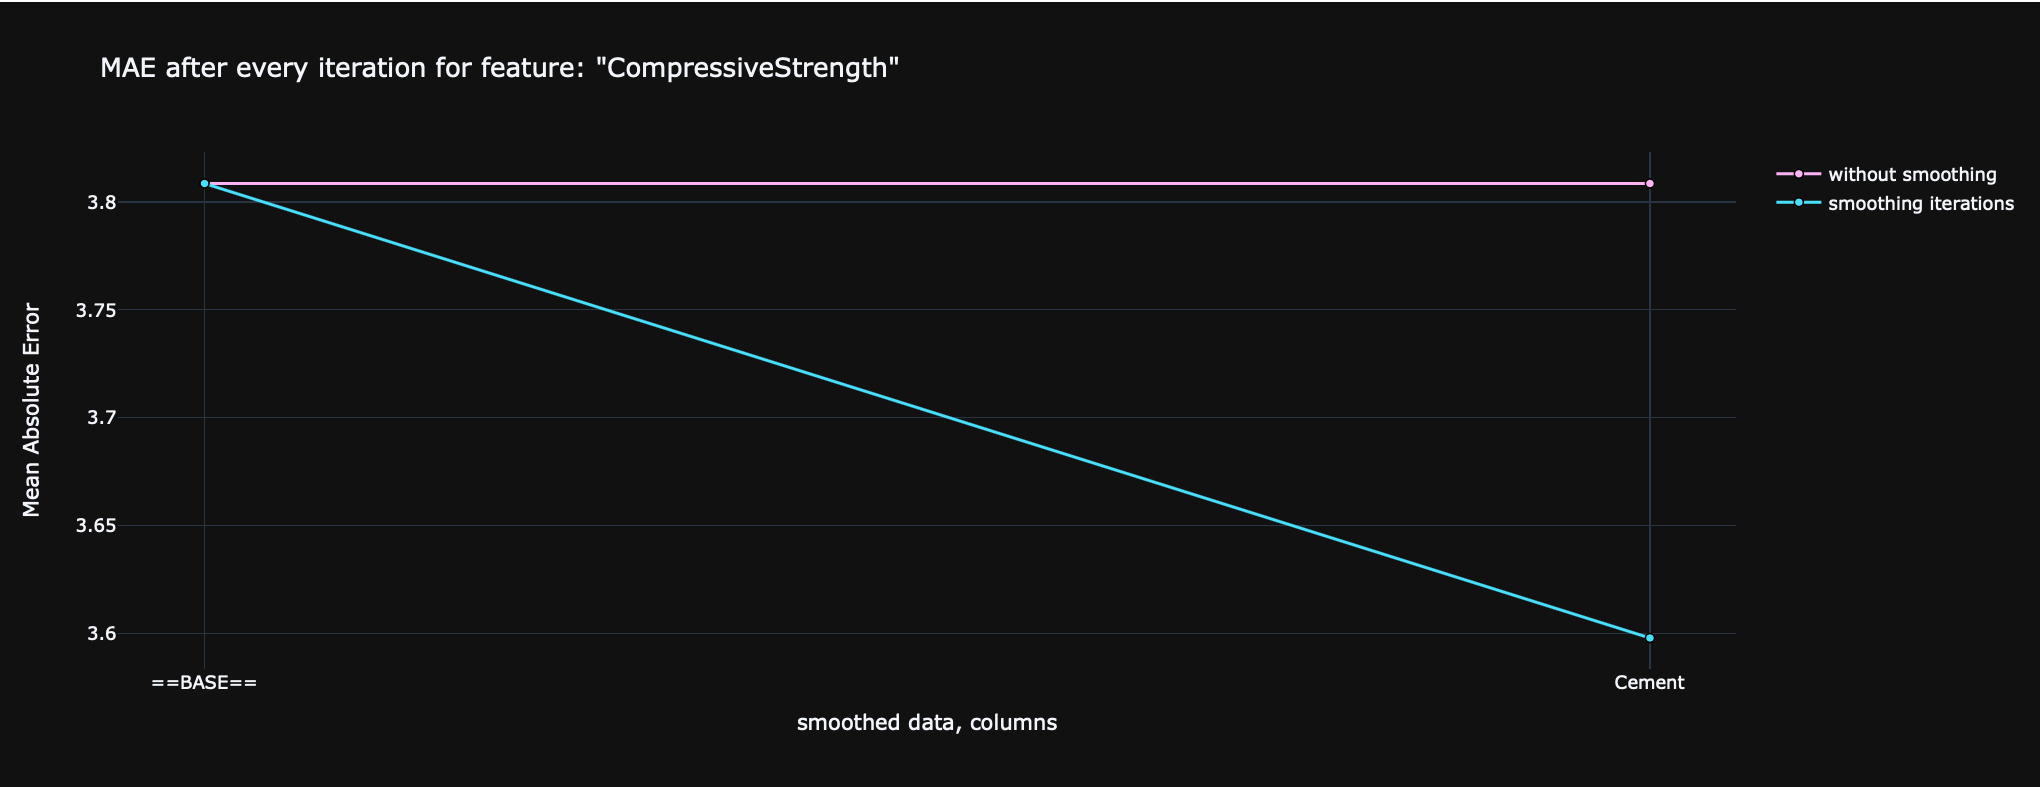

### data = "../input/fe-course-data/housing.csv"
### target_feature = "HouseAge"

# !!! WITHOUT IMPROVEMENT

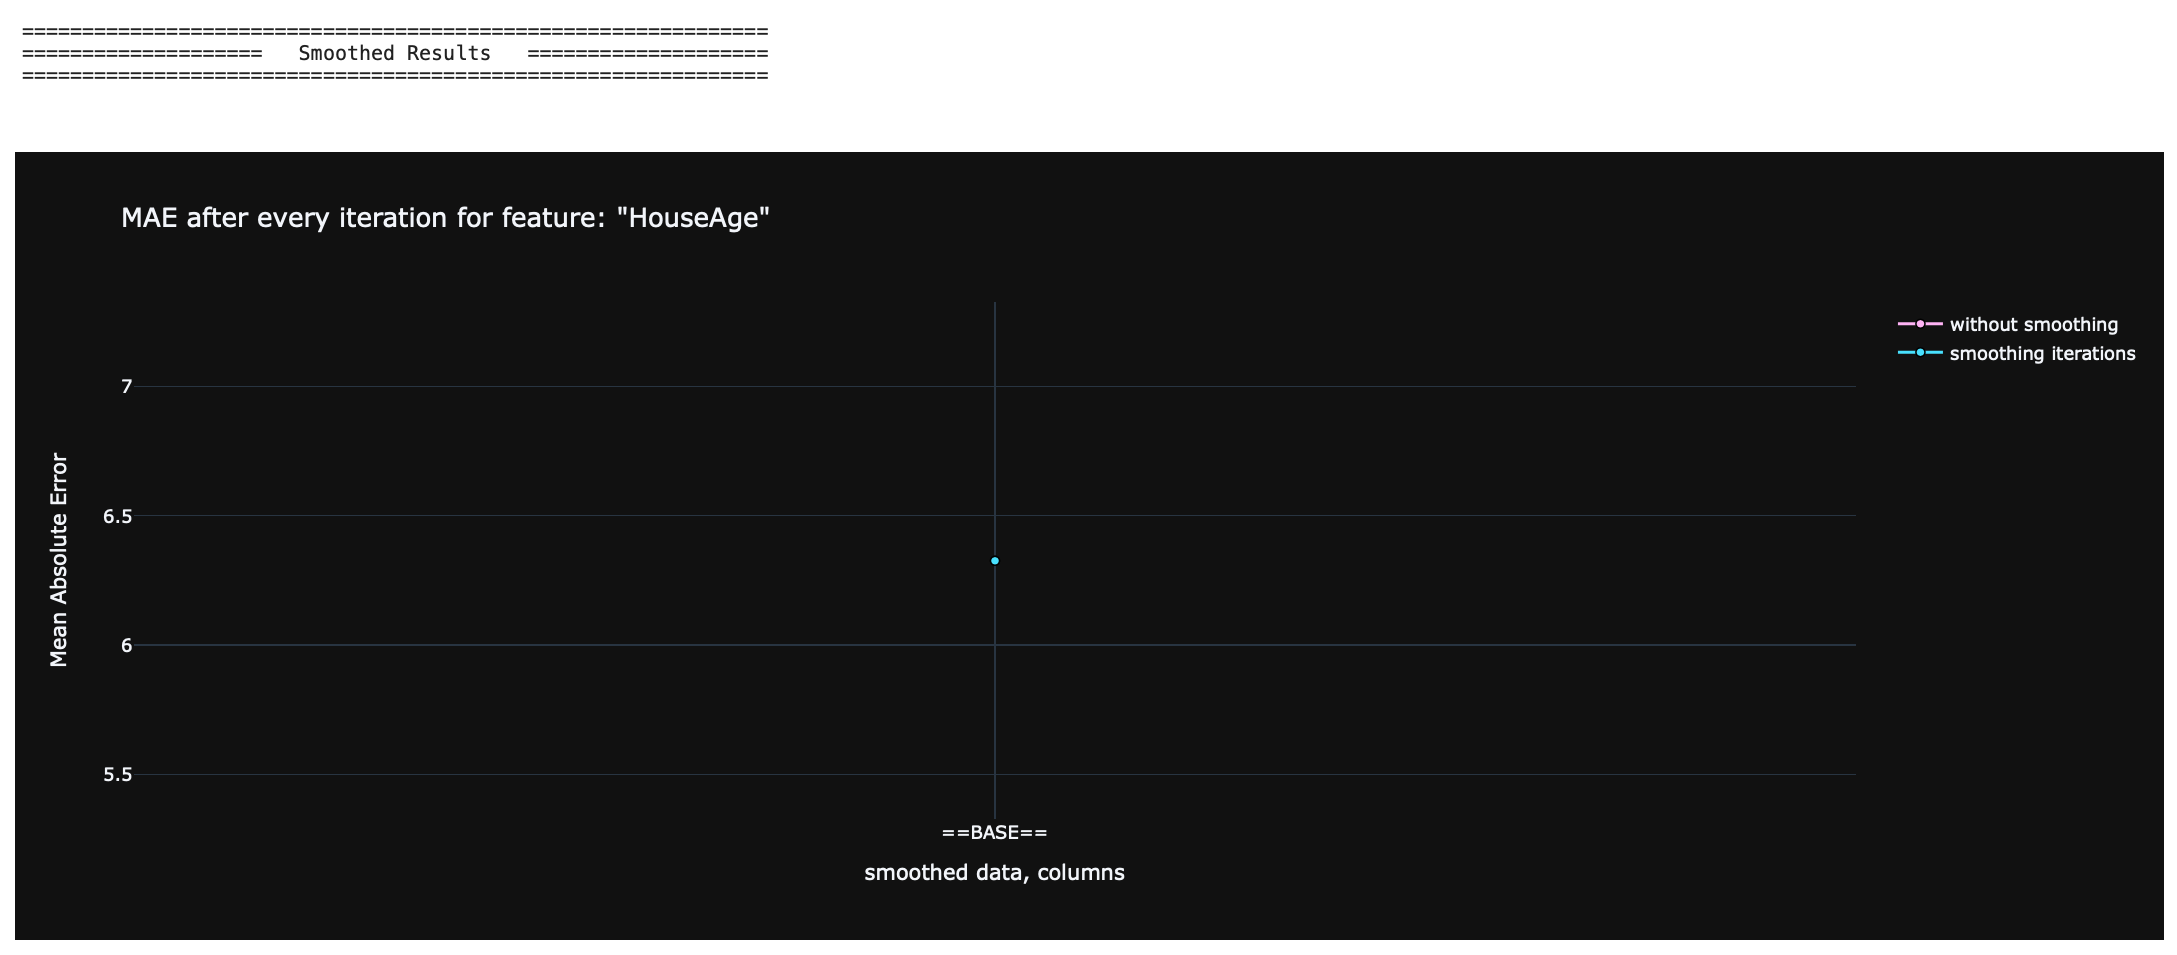

### data = "../input/fe-course-data/ames.csv"
### target_feature = "SalePrice"

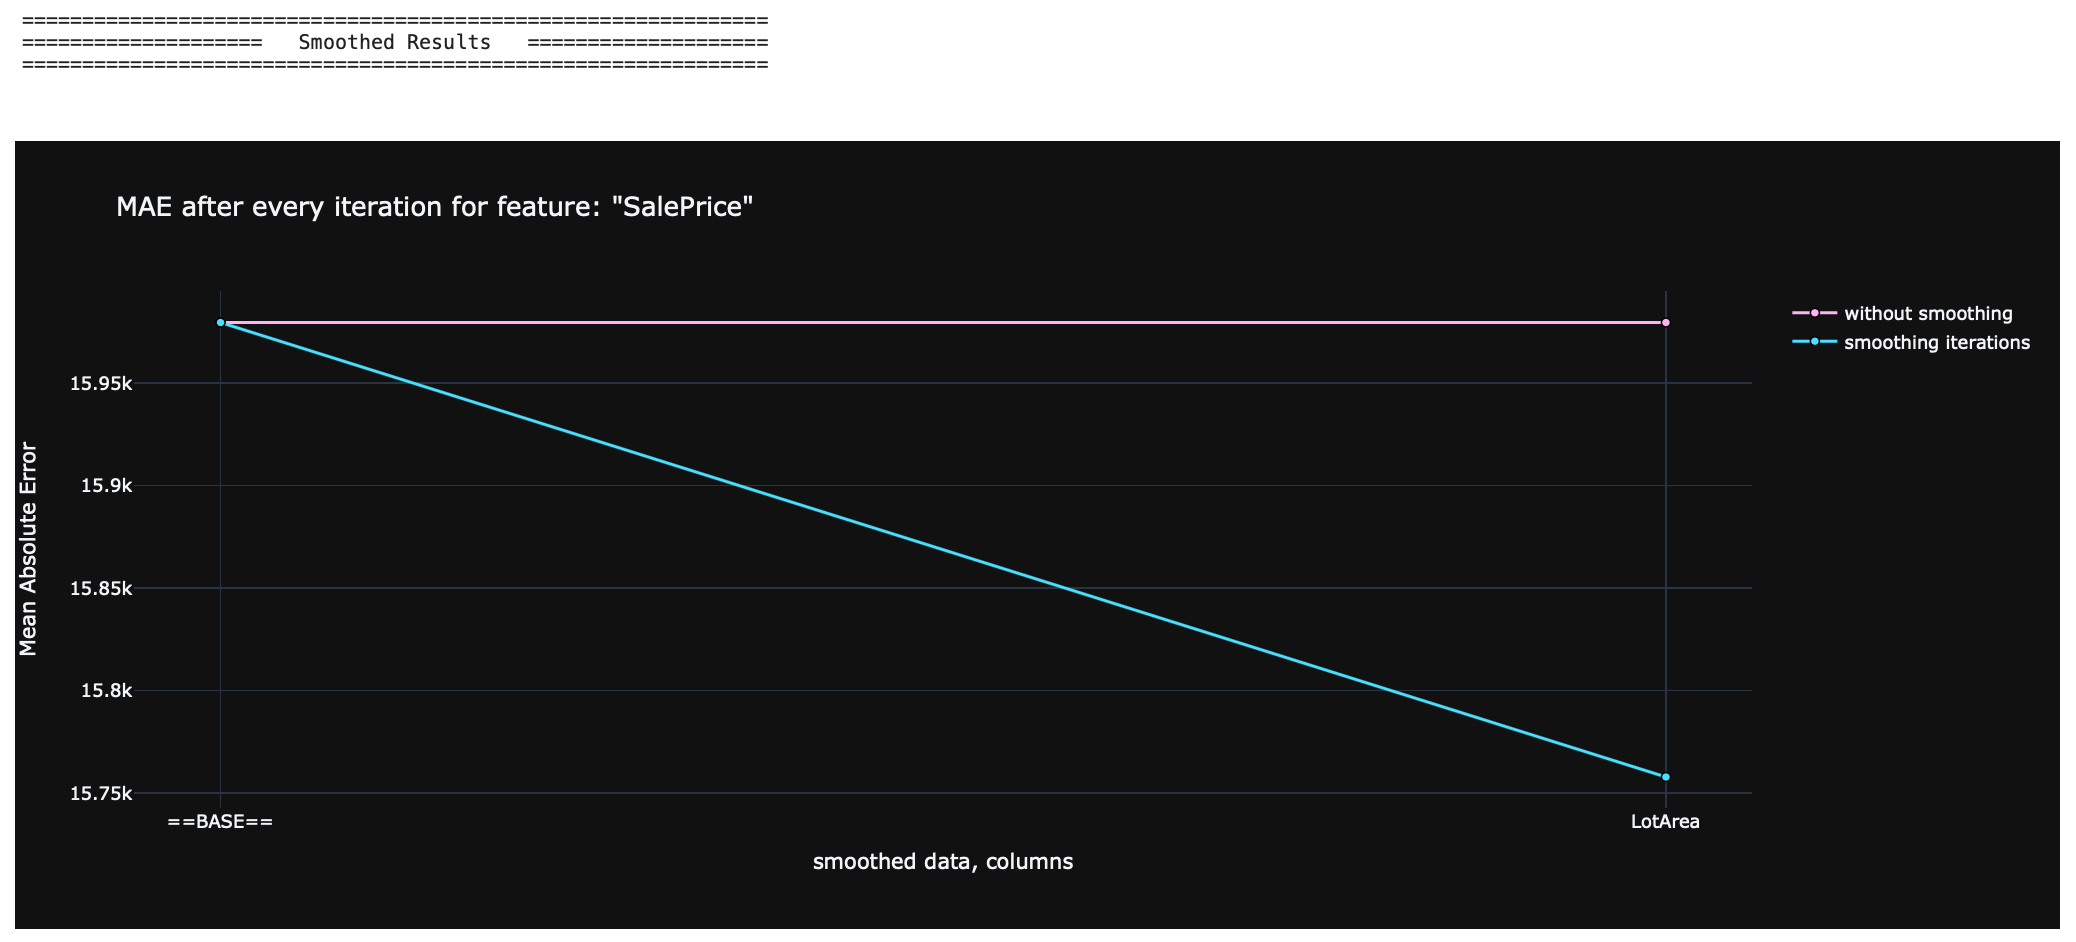

# ========== Data smoothing CLASSIFICATION ========== 

In [ ]:
data = "../input/fe-course-data/autos.csv"     
target_feature = "num_of_doors"


# data = "../input/fe-course-data/ames.csv"
# target_feature = "SaleCondition"

# data = "../input/fe-course-data/bike-sharing.csv"
# target_feature = "hr"


df = pd.read_csv(data)

predictors = list(df.columns)
predictors.remove(target_feature)

df

In [ ]:
encoding(df)

In [ ]:
df[[target_feature]] = df[target_feature].astype('int64')


for col in predictors:
    min_x = df[[col]].min()
    max_x = df[[col]].max()
    df[[col]] = (df[[col]] - min_x) / (max_x - min_x)
    

In [ ]:
X = df[predictors]
y = df[[target_feature]]

print(f'target value counts: {y.value_counts()} \n\n')

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=test_size_fraction, random_state=split_random_state)

train_X.reset_index(drop=True, inplace=True)
test_X.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)
test_y.reset_index(drop=True, inplace=True)


print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

In [ ]:
# for preprocessed train_X, train_y, test_X, test_y

def smoothing_classification(train_X, train_y, test_X, test_y, ML_weight=0.8):
    import numpy as np
    import pandas as pd
    import plotly.graph_objs as go
    from lightgbm import LGBMClassifier
    from lightgbm import LGBMRegressor
    from sklearn.metrics import f1_score

    
    global results
    
    REAL_VALUE_weight = 1 - ML_weight

    
    def score(train_X, train_y, test_X, test_y):
        model = LGBMClassifier(random_state=0).fit(train_X, train_y)
        predict = model.predict(test_X)
        score = f1_score(predict, test_y, average='weighted')
        return score 
    
    
    def plots(results, target_feature):
        baseline = []
        for el in results.index[:]:
            baseline.append(results.iloc[0,0])
 
        trace1 = go.Scatter(
                            x=results.index, 
                            y=baseline, 
                            name="without smoothing", 
                            marker=dict(color = '#FFB3F7',
                                     line=dict(color='#000000',width=1)))
        trace2 = go.Scatter(
                            x=results.index, 
                            y=results['score'], 
                            name="smoothing iterations", 
                            marker=dict(color = '#47E0FF',
                                     line=dict(color='#000000',width=1)))
        layout = go.Layout(hovermode='closest', 
                           title = f'f1_score(average=weighted) after every iteration for feature: "{target_feature}"' ,
                           xaxis = dict(title = 'smoothed data, columns'), 
                           yaxis = dict(title = 'f1_score(average=weighted)'), 
                           template= "plotly_dark")
        fig = go.Figure(data = [trace1, trace2], layout=layout)
        return fig.show()
    
    
    def iteration_score(train_X, train_y, test_X, test_y, results, all_columns, target_feature):
        for col in all_columns:
            df_new = pd.concat([train_X,train_y], axis=1)
            X = df_new.copy()
            y = X.pop(col)

            model = LGBMRegressor(random_state=0).fit(X, y)
            new_col_values = model.predict(X)
            df_new[[col]] = new_col_values * ML_weight + y * REAL_VALUE_weight

            train_X = df_new.copy()
            train_y = train_X.pop(target_feature)
            train_y = train_y.astype('int64')
            
            results.loc[col, 'score'] = score(train_X, train_y, test_X, test_y)
            
        plots(results, target_feature)
        return train_X, train_y, test_X, test_y, results, target_feature


    def delete_worst_features(results):
        counter = 1
        drop = []
        for el in results.index[counter:]:
            if results.loc[el, 'score'] <= results.iloc[counter - 1, 0]:
                drop.append(el)
            counter +=1
        results.drop(index = drop, inplace=True)
        return results

    


    target_feature = list(train_y.columns)[0]
    all_columns = (list(train_X.columns))
    all_columns.append(target_feature)
    
    results = pd.DataFrame()
    results.loc['==BASE==', 'score'] = score(train_X, train_y, test_X, test_y, )
    
    iteration_score(train_X, train_y, test_X, test_y, results, all_columns, target_feature)
    delete_worst_features(results)
    
    while len(all_columns) > len(list(results.index[1:])):
        all_columns = list(results.index[1:])
        iteration_score(train_X, train_y, test_X, test_y, results, all_columns, target_feature)
        delete_worst_features(results)
    
    print('\n\n')
    print('==============================================================')
    print('====================   Smoothed Results   ====================')
    print('==============================================================')
    print('\n\n')
    train_X, train_y, test_X, test_y, results, target_feature = \
    iteration_score(train_X, train_y, test_X, test_y, results, all_columns, target_feature)
    train_y = pd.DataFrame(train_y)
    return train_X, train_y, test_X, test_y

In [ ]:
train_X, train_y, test_X, test_y = smoothing_classification(train_X, train_y, test_X, test_y, ML_weight=0.8)

# CHECK

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

model = LGBMClassifier(random_state=0).fit(train_X, train_y)
predict = model.predict(test_X)
score = f1_score(predict, test_y, average='weighted')
score

# Once again))

In [ ]:
train_X, train_y, test_X, test_y = smoothing_classification(train_X, train_y, test_X, test_y, ML_weight=0.8)

# Once again CHECK

In [ ]:
model = LGBMClassifier(random_state=0).fit(train_X, train_y)
predict = model.predict(test_X)
score = f1_score(predict, test_y, average='weighted')
score

# Thank you for your attention! )